# Assignment 2
#### Name: Jaimon Thyparambil Thomas
#### Student ID: 29566428

## Part B. Neural Network vs. Perceptron

#### In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results


### Question 2 [Neural Network’s Decision Boundary, 30 Marks]
#### I. Load Task2B_train.csv and Task2B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your PDF report.


Loading necessary libraries

In [1]:
library(reshape2) # used for melt function
library(ggplot2)        # Used for drawing plots

Warning message:
"package 'reshape2' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"

In [2]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}
####################### PERCEPTRON #######################
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z) { 
  return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}
## the derivative of the activation function (tanh here)
h.d <- function(z) {
return (1-(h(z))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
  if (plotting){plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')}
  return(list(W1, W2, b1, b2))
}

####################### Assignment 3.B #######################
# Read the datasets
set.seed(1234)          # set random seed
list[X1,T1] <- read.data('Task2B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('Task2B_test.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 



#### II. Train two perceptron models on the loaded training data by setting the learning rates η to .01 and .09 respectively, using a code from Activity 3.1. Calculate the test errors of two models and find the best η and its corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your PDF report.

#### Hint: Note that you must remove NA records from the datasets (using “complete.cases()’ function). You may also choose to change the labels from [0, 1] to [-1, +1] for your convenience. If you decided to use the code from Activity 3.1, you may need to change some initial settings (e.g., epsilon and tau.max). Finally, remember that perceptron is sensitive to initial weights. Therefore, we recommend to run your code a few times with different initial weights

For η = .01

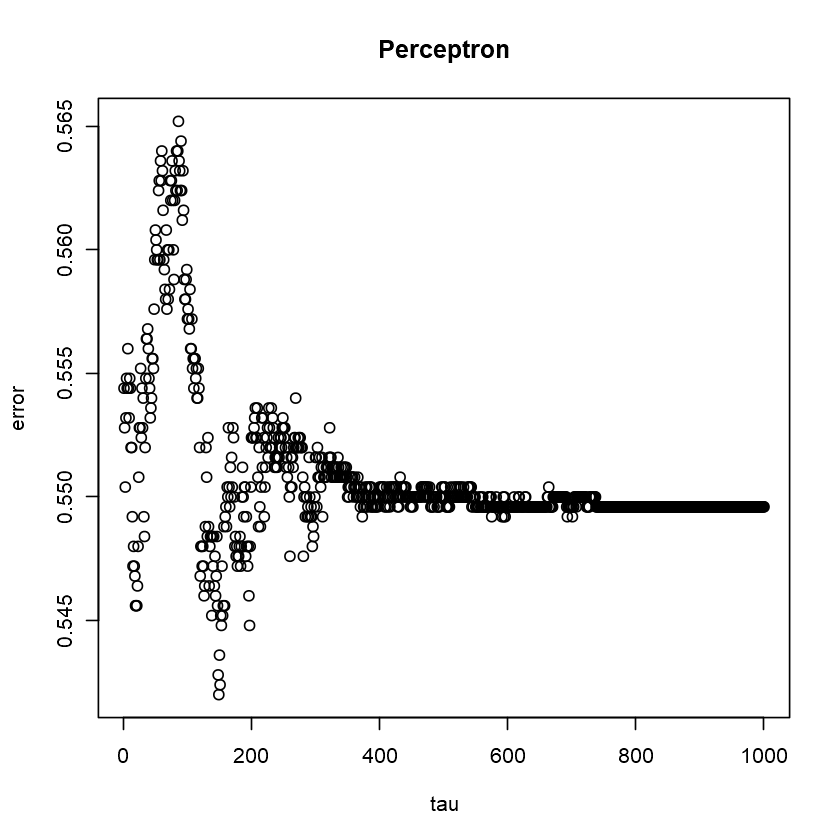

In [3]:
set.seed(111)          # set random seed
W.eta.01<-perceptron.build(X1, T1,eta=0.01, tau.max = 1000, plotting = TRUE) # Run this a few times until you are happy with the result

For η = .09

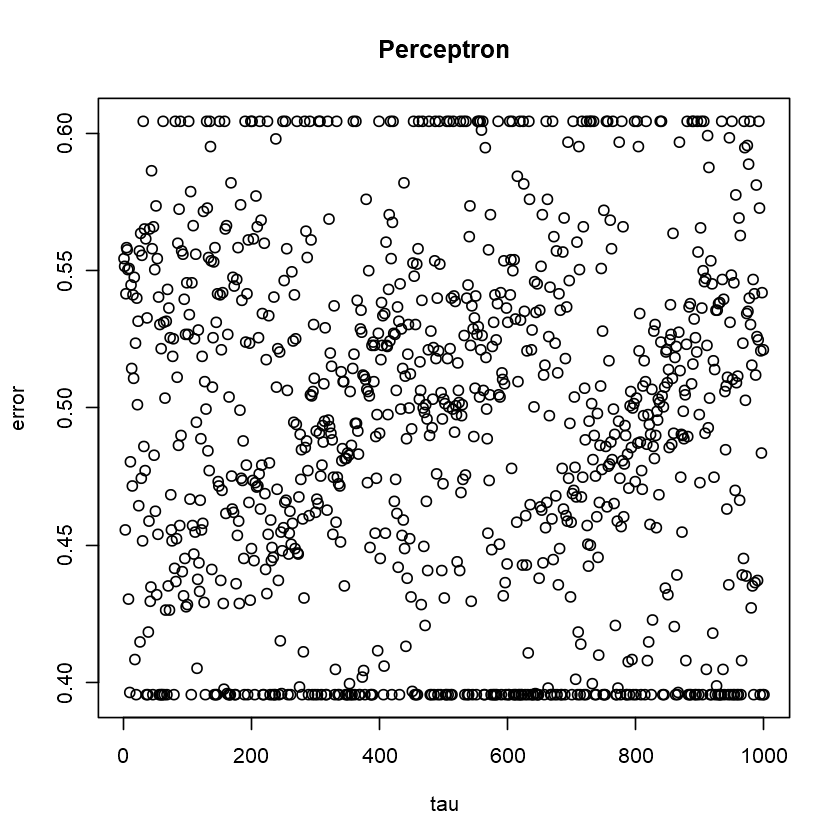

In [4]:
set.seed(111)          # set random seed
W.eta.09<-perceptron.build(X1, T1,eta=0.09, tau.max = 1000, plotting = TRUE) # Run this a few times until you are happy with the result

Calculating the test error for both eta = 0.09 and eta = 0.01

In [5]:
Phi.test <- as.matrix(cbind(1, X2)) # add a column of 1 as phi_0

In [6]:
error.eta.01 = (sum((perceptron.predict(Phi.test,W.eta.01)*T2)>0))
error.eta.09 = (sum((perceptron.predict(Phi.test,W.eta.09)*T2)>0))
if(error.eta.09 >= error.eta.01){
    print("Eta = 0.01 seems to perform better compared to eta =0.09 ");
}else{
        print("Eta = 0.09 seems to perform better compared to eta =0.01 ");
}

[1] "Eta = 0.01 seems to perform better compared to eta =0.09 "


Therefore the best model we have selected is for eta = 0.01

#### plot on for predicted values

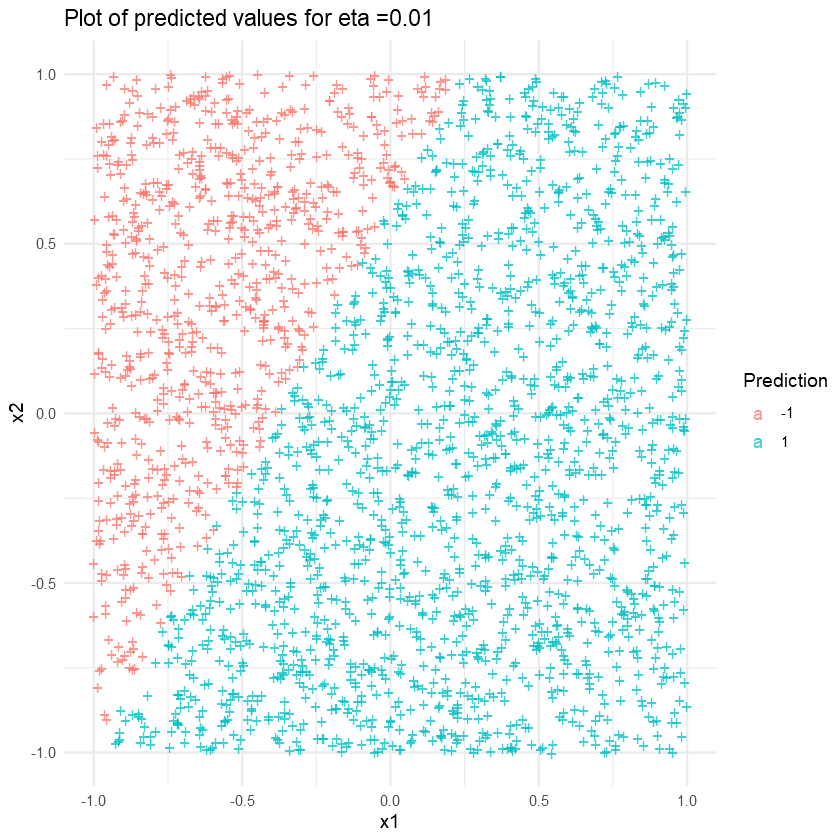

In [7]:
# Visualizations
## Ploting the decision boundary
ggplot(data=as.data.frame(Phi.test), aes(x=x1, y=x2, label=ifelse(T!='+1', '+', '-'), color=factor(perceptron.predict(Phi.test,W.eta.01))))+
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Plot of predicted values for eta =0.01' ) +
    theme_minimal()

#### plot on whether predicted values vs actual for test data
If the predicted and the actual values are same them value is True else it is false

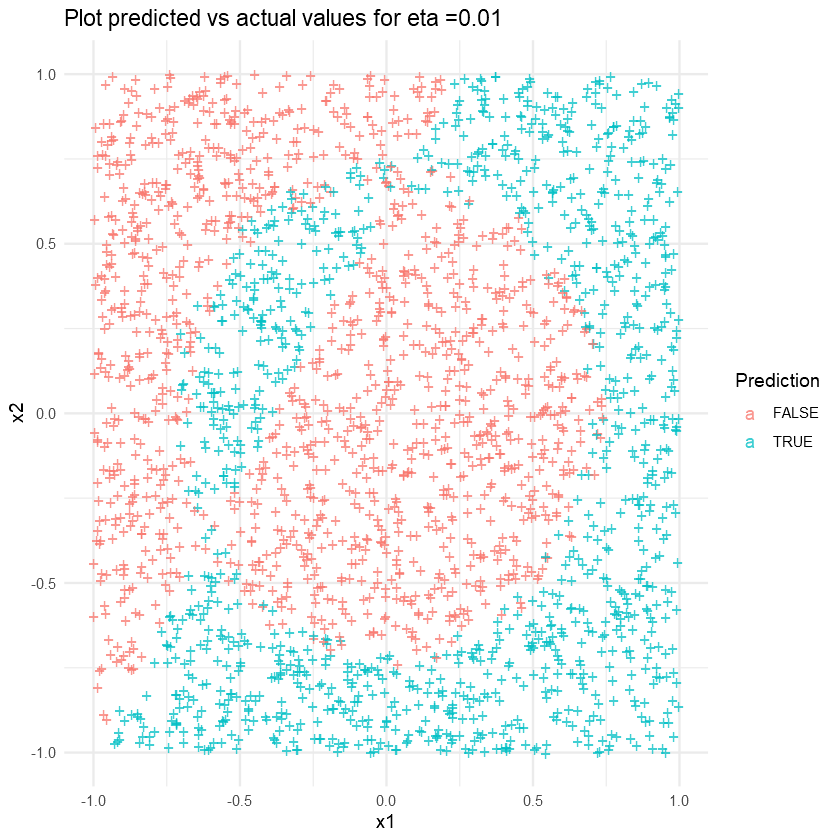

In [8]:
# Visualizations
## Ploting the decision boundary
ggplot(data=as.data.frame(Phi.test), aes(x=x1, y=x2, label=ifelse(T!='+1', '+', '-'), color=factor((perceptron.predict(Phi.test,W.eta.01)*T2)>0)))+
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Plot predicted vs actual values for eta =0.01' ) +
    theme_minimal()

#### III. For each combination of K (i.e, number of units in the hidden layer) in {5, 10, 15, …, 100} and µ (learning rate) in {0.01, 0.09}, run the 3-layer Neural Network given to you in Activity 5.1 and record testing error for each of them (40 models will be developed, based on all possible combinations). Plot the error for µ 0.01 and 0.09 vs K (one line for µ 0.01 and another line for µ 0.09 in a plot) and attach it to your PDF report. Based on this plot, find the best combination of K and µ and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your PDF report.

#### Hint: In case you choose to use the provided examples in Activity 5.1, you may need to transpose the dataset (using “t()” function) and use different values for parameter settings (e.g., lambda).

In [9]:
set.seed(111)          # set random seed
error <- data.frame(i=1:20,'K' = rep(0,20) ,'eta.0.01'=rep(0,20), 'eta.0.09'=rep(0,20))
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))
i=1
for (k in seq(5, 100, 5)) {
      list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=FALSE, epoch.max=50, eta = 0.01, lambda = 0.01)
      error[i,'K'] = k
      error[i,'eta.0.01'] = error.rate(nn.predict(X2.t, W1, W2, b1, b2), T2)
      list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=FALSE, epoch.max=50, eta = 0.09, lambda = 0.01)
      error[i,'eta.0.09'] = error.rate(nn.predict(X2.t, W1, W2, b1, b2), T2)
    i=i+1
}

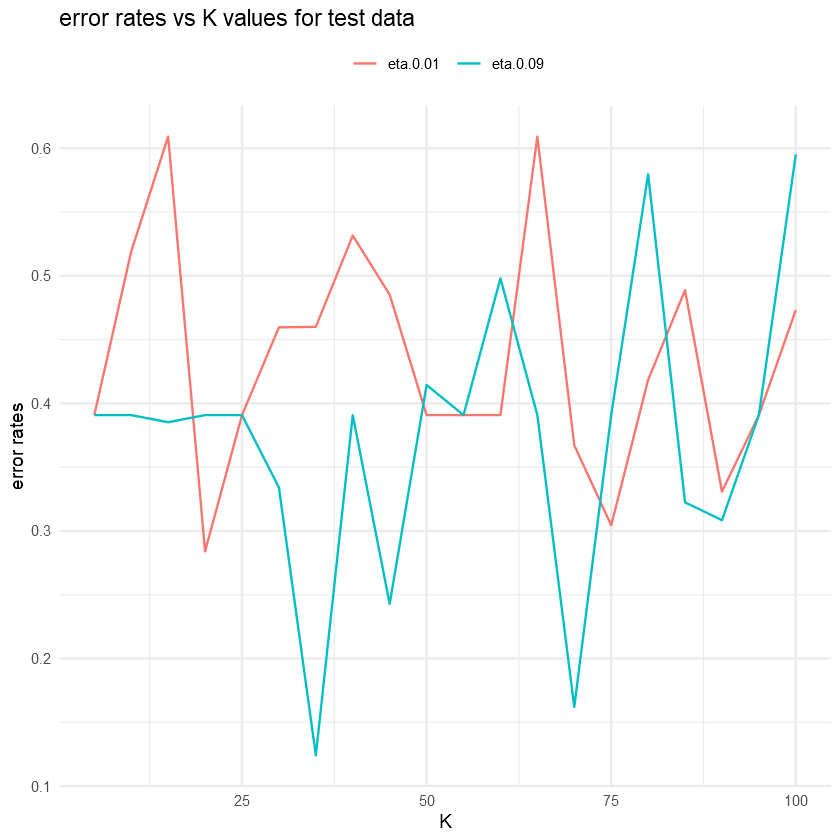

In [10]:
error.m <- melt(error[,c('K','eta.0.01','eta.0.09')], id='K') # reshape for visualization
names(error.m) <- c('K', 'eta', 'error')
ggplot(data=error.m, aes(x=K, y=error, color=eta)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "error rates vs K values for test data", y="error rates",
           x = "K")

In [11]:
#function used to find the min value
#params
#dataframe - data frame used
#key.column.number - column no which has the Key in the data frame 
#value.column.number - column no which has the value in the data frame 
find.min.key <- function(dataframe, key.column.number = 1,value.column.number = 3){
    minVal = -1 #used to store the min value
    minK = NULL #used to store the Key of the min value
    minEta = NULL
    for(i in 1:nrow(dataframe)) {
        if(minVal == -1){
            #intialising minval and key for the first entry
            minVal = dataframe[i,value.column.number]
            minK = dataframe[i,key.column.number]
        }
        else if(dataframe[i,value.column.number] < minVal){
            #updating the key and min value when current key has min value compare to previous val
            minVal = dataframe[i,value.column.number]
            minK = dataframe[i,key.column.number]
        }
    }
    return (minK)
}

In [12]:
minK = find.min.key(error.m)
minETA = find.min.key(error.m,2,3)
minETA

[1] eta.0.09
Levels: eta.0.01 eta.0.09

In [13]:
cat("Min value error rates is for K = ",minK,"with eta 0.09")

Min value error rates is for K =  35 with eta 0.09

In [14]:
set.seed(111)          # set random seed
list[W1, W2, b1, b2]<- nn.build(minK, X1.t, T1, plotting=FALSE, epoch.max=50, eta = 0.09, lambda = 0.01)
predicted.test.val = nn.predict(X2.t, W1, W2, b1, b2)

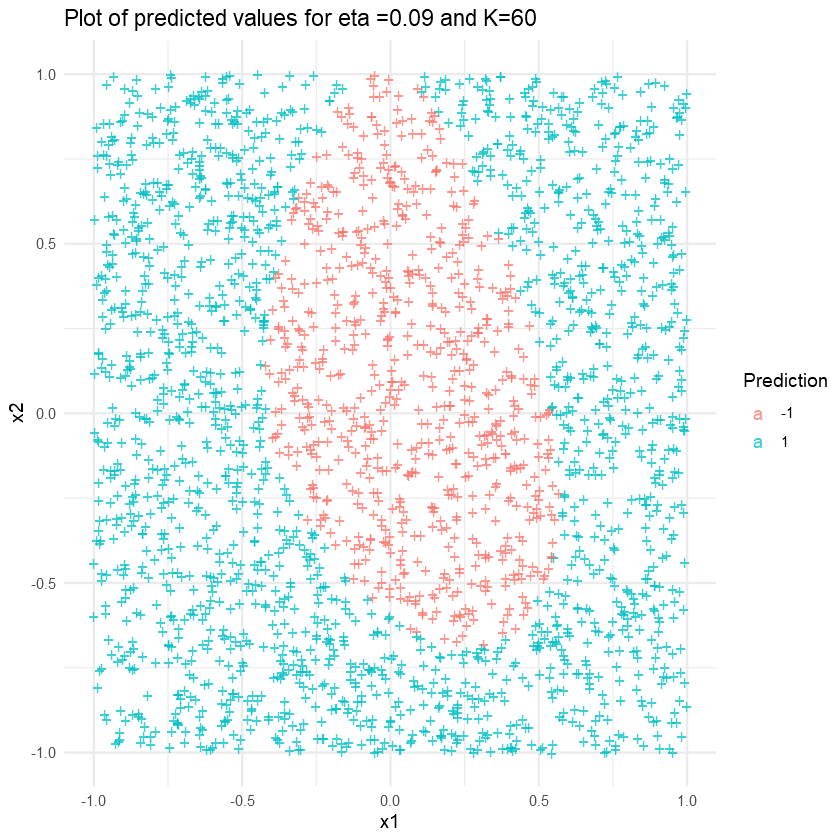

In [15]:
# Visualizations
## Ploting the decision boundary
ggplot(data=as.data.frame(Phi.test), aes(x=x1, y=x2, label=ifelse(T!='+1', '+', '-'), color=factor(predicted.test.val)))+
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Plot of predicted values for eta =0.09 and K=60' ) +
    theme_minimal()

#### IV. In your PDF report, explain the reason(s) responsible for such difference between perceptron and a 3-layer NN by comparing the plots you generated in Steps II and III.

#### Hint: Look at the plots and think about the model assumptions.

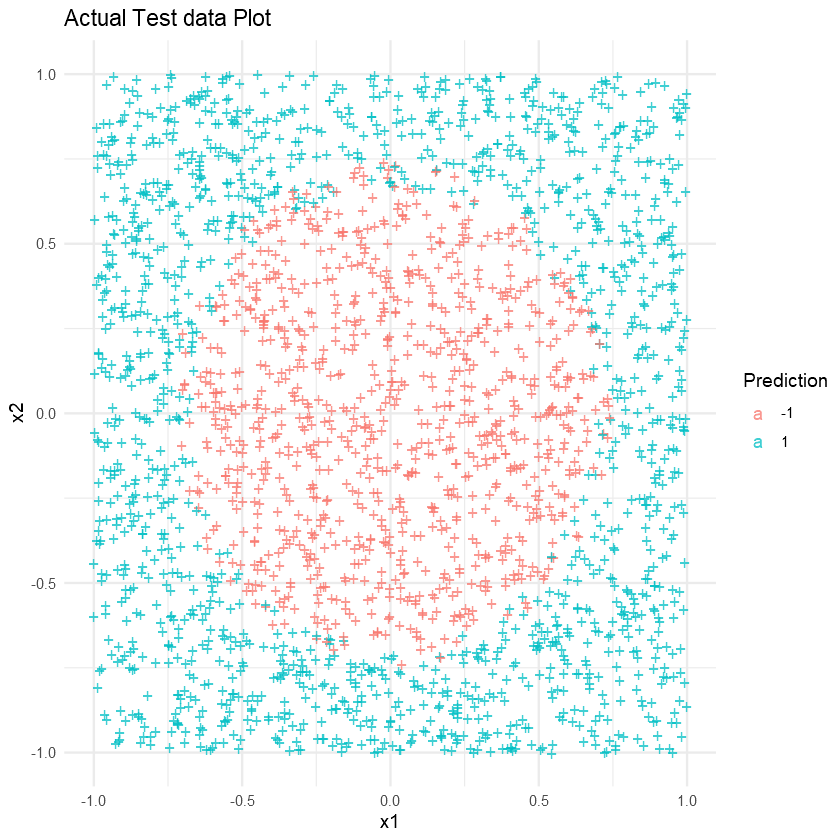

In [16]:
# Visualizations
## Ploting the decision boundary
ggplot(data=as.data.frame(Phi.test), aes(x=x1, y=x2, label=ifelse(T!='+1', '+', '-'), color=factor(T2)))+
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Actual Test data Plot' ) +
    theme_minimal()

One of the main reasons why there is such a difference in the plot is due to the fact that test data is actually a non linearly seperable data and perceptron can only classify linearly seperable data properly. Whereas a 3 layer nn network can classify even a non linearly seperable data. That is the main reason nn was able to predict betterly compared to perceptron in this data